<a href="https://colab.research.google.com/github/mariojdepeine/beerclassification/blob/main/Aprilclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -Uqq fastbook

     |████████████████████████████████| 727kB 9.1MB/s 
     |████████████████████████████████| 1.2MB 19.0MB/s 
     |████████████████████████████████| 194kB 38.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 12.8MB 43.2MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
pip install streamlit

     |████████████████████████████████| 8.2MB 7.2MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 112kB 50.8MB/s 
     |████████████████████████████████| 4.6MB 55.4MB/s 
     |████████████████████████████████| 163kB 57.4MB/s 
     |████████████████████████████████| 122kB 60.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp37-none-any.whl size=13448 sha256=662eef845051737bf811383348af47ee79015904702d6abc5875acd3e028236f
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built blinker
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.3 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [4]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [7]:
!ls "/content/gdrive/My Drive/Beer ML Project"

'Anheuser Busch Budweiser'	   'Lawson Goldmaster'
'Anno Eurohop'			   'Lindemans Framboise'
'Asahi Super Dry'		   'Lindemans Kriek'
'Aventinus Eisbock'		   'Lindemans Pecheresse'
'Baird Wabi Sabi Japan Pale Ale'   'Lion Stout'
'Chimay Blue'			   'Minoh Stout'
'Chimay Red'			   'Oldfoghorn Barleywine'
'Coedo Shikkoku Black Lager'	    Orval
'Coopers Best Extra Stout'	   'Oude Geuze Boon'
'Far Yeast Tokyo Blonde'	   'rindou ALT'
'Far Yeast Tokyo IPA'		   'Sam Smith Pale Ale'
'Ginga Kogen Hefeweizen'	   'Sapporo Sorachi 1984'
'Granagri Weizen'		   'Sierra Nevada Hazy IPA'
'Guinness Draught'		   'Sierra Nevada Pale Ale'
'Guinness Extra Stout'		   'Star Select Guimugi'
'Hideji Kuri Kuro'		   'St Louis Framboise'
'Hitachino Nest Espresso Stout'    'Suntory Blue'
'Hitachino Nest White'		   'Suntory Premium Malts Black'
'Hoegaarden Witbier'		   'Suntory The Premium Malts Kaoru'
'Hofbrau Dunkel'		   'Suruga Bay Imperial IPA'
'Hofbrau Maibock'		   'SVB On the Cloud'
'Hofbrau Oktoberfestbier'	   "

In [11]:
path = "/content/gdrive/My Drive/Beer ML Project"

In [14]:
fns = get_image_files(path)


In [ ]:
failed = verify_images(fns)
failed.map(Path.unlink);

In [57]:
beers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = beers.dataloaders(path)

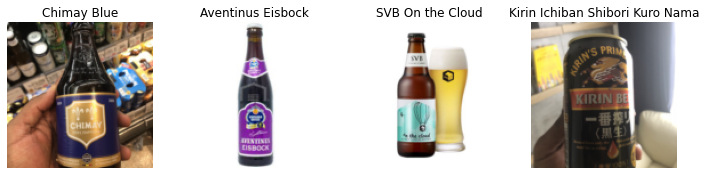

In [58]:
dls.valid.show_batch(max_n=4, nrows=1)


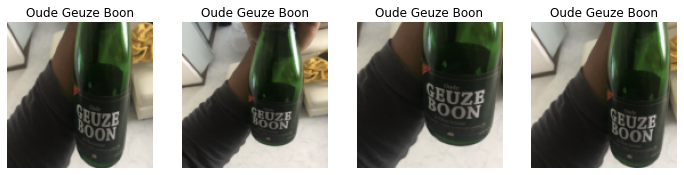

In [59]:
beers = beers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = beers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

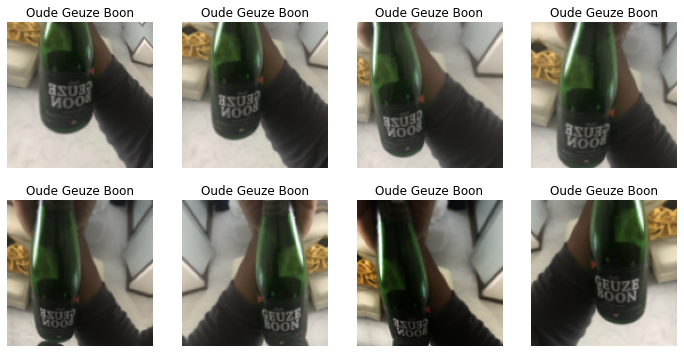

In [60]:
beers = beers.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = beers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [61]:
beers = beers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = beers.dataloaders(path)

In [62]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.329509,0.529798,0.141946,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.579215,0.161635,0.033493,00:32
1,0.304821,0.056341,0.009569,00:32
2,0.167974,0.038185,0.006380,00:32
3,0.103683,0.035187,0.007974,00:32


In [63]:
interp= ClassificationInterpretation.from_learner(learn)

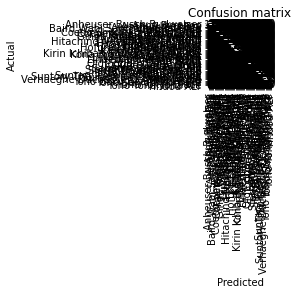

In [64]:
interp.plot_confusion_matrix()

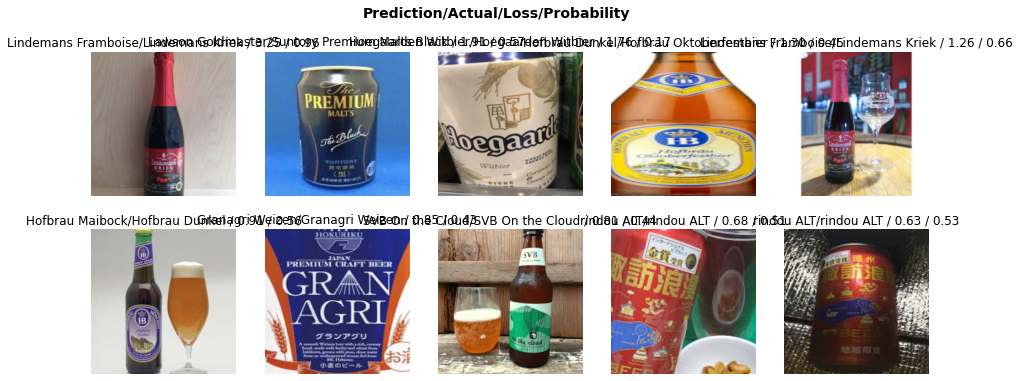

In [65]:
interp.plot_top_losses(10, nrows=2)

In [66]:
cleaner=ImageClassifierCleaner(learn)
cleaner

In [56]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [67]:
learn.export('beerpairings.pkl')

In [73]:
path = Path()
learn_inf = load_learner(path/'beerpairings.pkl')

In [80]:
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
import os

from IPython.display import Image
from IPython.core.display import HTML

In [81]:
from fastai.vision.widgets import *
from fastai.vision.all import *

from pathlib import Path

import streamlit as st

class Predict:
    def __init__(self, filename):
        self.learn_inference = load_learner(Path()/filename)
        self.img = self.get_image_from_upload()
        if self.img is not None:
            self.display_output()
            self.get_prediction()
    
    @staticmethod
    def get_image_from_upload():
        uploaded_file = st.file_uploader("Upload Files",type=['png','jpeg', 'jpg'])
        if uploaded_file is not None:
            return PILImage.create((uploaded_file))
        return None

    def display_output(self):
        st.image(self.img.to_thumb(500,500), caption='Uploaded Image')

    def get_prediction(self):

        if st.button('Classify'):
            pred, pred_idx, probs = self.learn_inference.predict(self.img)
            st.write(f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}')
        else: 
            st.write(f'Click the button to classify') 

if __name__=='__main__':

    file_name='beerpairings.pkl'

    predictor = Predict(file_name)

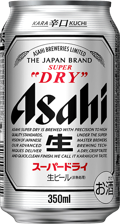

In [92]:
# Sample image
ims = ['https://www.asahigroup-holdings.com/img/brand/img_superdry.png']
dest = 'test_beer.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(224,224)

In [93]:
learn_inf.predict('test_beer.jpg')


('Asahi Super Dry',
 tensor(2),
 tensor([2.6142e-05, 4.0986e-06, 9.8552e-01, 7.7734e-05, 4.9643e-06, 7.5039e-06, 3.0122e-05, 4.8168e-05, 1.4047e-05, 8.6514e-05, 4.6873e-04, 1.1438e-04, 4.7999e-05, 3.6000e-05, 2.2323e-04, 8.5359e-06,
         1.4075e-06, 8.2851e-05, 8.7102e-06, 2.5076e-04, 1.5324e-04, 2.1343e-04, 5.7202e-06, 4.5825e-05, 7.7616e-06, 3.7897e-05, 1.4906e-05, 9.1538e-07, 3.5031e-04, 4.8904e-03, 1.4752e-05, 6.2001e-05,
         6.5535e-06, 2.8220e-05, 2.4775e-05, 7.7305e-06, 1.8192e-05, 1.5455e-05, 1.7471e-05, 7.0328e-05, 1.1335e-05, 3.9861e-06, 4.3518e-04, 5.5165e-04, 1.3237e-05, 4.2252e-06, 5.3147e-03, 5.2343e-05,
         4.1983e-06, 1.2815e-06, 1.9612e-04, 8.8028e-05, 2.3047e-05, 5.9852e-05, 5.8197e-06, 1.4109e-05, 1.6862e-04]))

In [94]:
learn_inf.dls.vocab

['Anheuser Busch Budweiser', 'Anno Eurohop', 'Asahi Super Dry', 'Aventinus Eisbock', 'Baird Wabi Sabi Japan Pale Ale', 'Chimay Blue', 'Chimay Red', 'Coedo Shikkoku Black Lager', 'Coopers Best Extra Stout', 'Far Yeast Tokyo Blonde', 'Far Yeast Tokyo IPA', 'Ginga Kogen Hefeweizen', 'Granagri Weizen', 'Guinness Draught', 'Guinness Extra Stout', 'Hideji Kuri Kuro', 'Hitachino Nest Espresso Stout', 'Hitachino Nest White', 'Hoegaarden Witbier', 'Hofbrau Dunkel', 'Hofbrau Maibock', 'Hofbrau Oktoberfestbier', 'Inedit Damm', 'Isekadoya Pale Ale', 'Kapuziner Weissbier', 'Kirin Ichiban Shibori', 'Kirin Ichiban Shibori Kuro Nama', 'Kona Big Wave Golden Ale', 'Lagunitas IPA', 'Lawson Goldmaster', 'Lindemans Framboise', 'Lindemans Kriek', 'Lindemans Pecheresse', 'Lion Stout', 'Minoh Stout', 'Oldfoghorn Barleywine', 'Orval', 'Oude Geuze Boon', 'SVB On the Cloud', 'Sam Smith Pale Ale', 'Sapporo Sorachi 1984', 'Sierra Nevada Hazy IPA', 'Sierra Nevada Pale Ale', 'St Louis Framboise', 'Star Select Guimug

In [97]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 2.5MB 7.9MB/s 
     |████████████████████████████████| 122kB 57.2MB/s 
     |████████████████████████████████| 552kB 48.7MB/s 
     |████████████████████████████████| 378kB 54.3MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
ERROR: nbdev 1.1.14 has requirement jupyter-client<=6.1.12, but you'll have jupyter-client 6.2.0 which is incompatible.
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.3 which is incompatible.
ERROR: jupyter-server 1.6.0 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


In [95]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [98]:
# Retrieving the uploaded image
img = PILImage.create(btn_upload.data[-1])

In [99]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [100]:
pred,pred_idx,probs = learn_inf.predict(img)

In [101]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Sapporo Sorachi 1984; Probability: 0.9898')

In [102]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [104]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [109]:
VBox([widgets.Label('Select your beer!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [110]:
git clone https://github.com/voila-dashboards/voila
cd voila
voila notebooks/Aprilclassifier.ipynb

SyntaxError: ignored